生成二分类样例数据：

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 2, random_state = 0)
y[y == 0] = -1

梯度提升树二分类实现：

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class gbdtc:
    """
    梯度提升树二分类算法
    """
    
    def __init__(self, n_estimators = 100, learning_rate = 0.1):
        # 梯度提升树弱学习器数量
        self.n_estimators = n_estimators
        # 学习速率
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        """
        梯度提升树二分类算法拟合
        """
        # 标签类
        self.y_classes = np.unique(y)
        # 标签类数量
        self.n_classes = len(self.y_classes)
        # 标签的平均值
        y_avg = np.average(y)
        # 初始化H0
        self.H0 = np.log((1 + y_avg) / (1 - y_avg)) / 2
        # 初始化预测值
        H = np.ones(X.shape[0]) * self.H0
        # 估计器数组
        estimators = []
        # 叶子结点取值数组
        gammas = []
        for k in range(self.n_estimators):
            # 计算 y_hat
            y_hat = 2 * np.multiply(y, 1 / (1 + np.exp(2 * np.multiply(y, H))))
            # 初始化决策回归树估计器
            estimator = DecisionTreeRegressor(max_depth = 3, criterion="friedman_mse")
            # 将 y_hat 当作标签值拟合训练集
            estimator.fit(X, y_hat)
            # 计算训练集在当前决策回归树的叶子结点
            leaf_ids = estimator.apply(X)
            # 每个叶子结点下包含的训练数据序号
            node_ids_dict = self.get_leaf_nodes(leaf_ids)
            # 叶子结点取值字典表
            gamma_dict = {}
            # 计算叶子结点取值
            for leaf_id, node_ids in node_ids_dict.items():
                # 当前叶子结点包含的 y_hat
                y_hat_sub = y_hat[node_ids]
                y_hat_sub_abs = np.abs(y_hat_sub)
                # 计算叶子结点取值
                gamma = np.sum(y_hat_sub) / np.sum(np.multiply(y_hat_sub_abs, 2 - y_hat_sub_abs))
                gamma_dict[leaf_id] = gamma
                # 更新预测值
                H[node_ids] += self.learning_rate * gamma
            estimators.append(estimator)
            gammas.append(gamma_dict)
        self.estimators = estimators
        self.gammas = gammas
        
    def predict(self, X):
        """
        梯度提升树二分类算法预测
        """
        # 初始化预测值
        H = np.ones(X.shape[0]) * self.H0
        # 遍历估计器
        for k in range(self.n_estimators):
            estimator = self.estimators[k]
            # 计算在当前决策回归树的叶子结点
            leaf_ids = estimator.apply(X)
            # 每个叶子结点下包含的数据序号
            node_ids_dict = self.get_leaf_nodes(leaf_ids)
            # 叶子结点取值字典表
            gamma_dict = self.gammas[k]
            # 计算预测值
            for leaf_id, node_ids in node_ids_dict.items():
                gamma = gamma_dict[leaf_id]
                H[node_ids] += self.learning_rate * gamma
        # 计算概率
        probs = np.zeros((X.shape[0], self.n_classes))
        probs[:, 0] = 1 / (1 + np.exp(2 * H))
        probs[:, 1] = 1 / (1 + np.exp(-2 * H))
        return self.y_classes.take(np.argmax(probs, axis=1), axis = 0)
    
    def get_leaf_nodes(self, leaf_ids):
        """
        每个叶子结点下包含的数据序号
        """
        node_ids_dict = {}
        for j in range(len(leaf_ids)):
            leaf_id = leaf_ids[j]
            node_ids = node_ids_dict.setdefault(leaf_id, [])
            node_ids.append(j)
        return node_ids_dict

梯度提升树二分类拟合：

In [3]:
clf = gbdtc()
clf.fit(X, y)

梯度提升树二分类可视化：

<IPython.core.display.Javascript object>


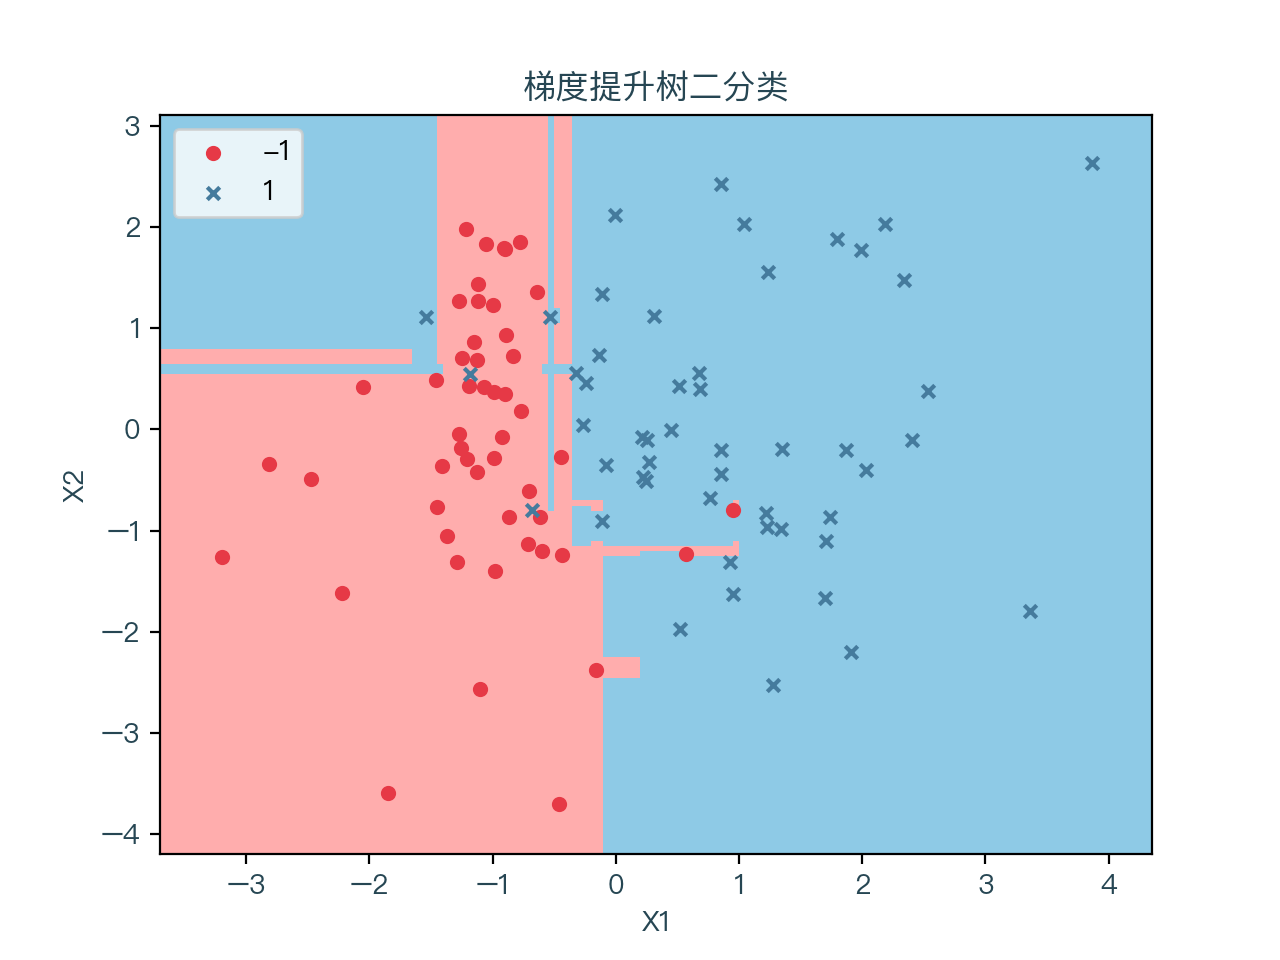

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('梯度提升树二分类', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

梯度提升树分类（scikit-learn）：

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

# 梯度提升树分类器
clf = GradientBoostingClassifier(n_estimators = 100, random_state = 0)
# 拟合数据集
clf = clf.fit(X, y)

梯度提升树可视化（scikit-learn）：

<IPython.core.display.Javascript object>


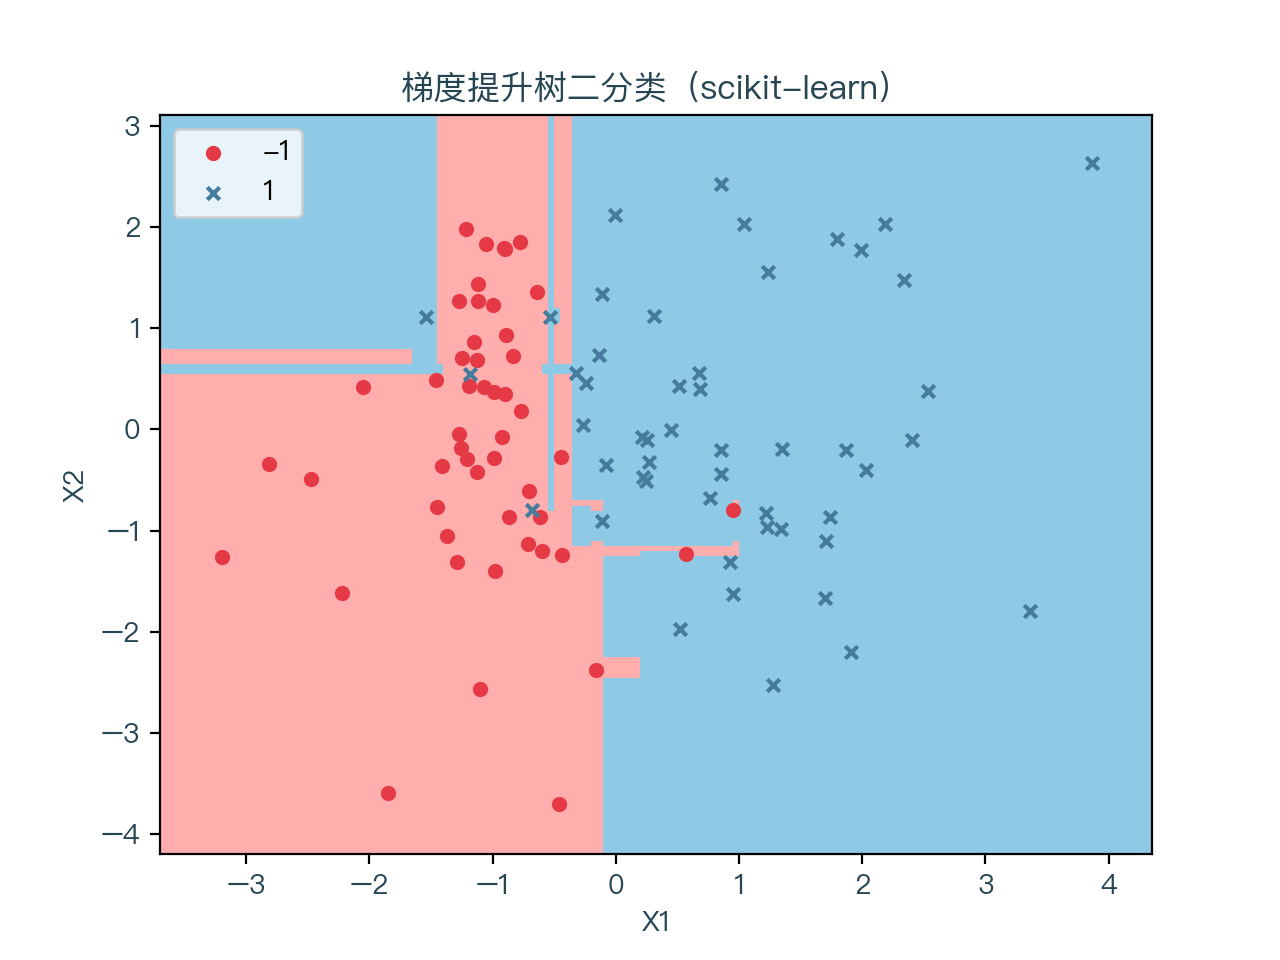

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6']
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==-1][:, 0]
y1 = X[y==-1][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)

ax.set_title('梯度提升树二分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2], ["-1", "1"], loc="upper left")
plt.show()

生成多分类样例数据：

In [7]:
import numpy as np
from sklearn.datasets import make_classification

X, y = make_classification(n_features = 2, n_informative = 2, n_redundant = 0, n_samples = 100, n_classes = 3, n_clusters_per_class = 1, random_state = 0)

梯度提升树多分类实现：

In [8]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class gbdtmc:
    """
    梯度提升树多分类算法
    """
    
    def __init__(self, n_estimators = 100, learning_rate = 0.1):
        # 梯度提升树弱学习器数量
        self.n_estimators = n_estimators
        # 学习速率
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        """
        梯度提升树多分类算法拟合
        """
        # 标签类，对应标签的数量
        self.y_classes, y_counts = np.unique(y, return_counts = True)
        # 标签类数量
        self.n_classes = len(self.y_classes)
        # 对标签进行One-Hot编码
        y_onehot = np.zeros((y.size, y.max() + 1))
        y_onehot[np.arange(y.size), y] = 1
        # 初始化 H0
        self.H0 = y_counts / X.shape[0]
        # 初始化预测值
        H = np.ones((X.shape[0], 1)).dot(self.H0.reshape(1, -1))
        # 估计器数组
        estimators = []
        # 叶子结点取值数组
        gammas = []
        # 遍历 n_estimators 次
        for k in range(self.n_estimators):
            H_exp = np.exp(H)
            H_exp_sum = np.sum(H_exp, axis = 1)
            # 估计器
            sub_estimators = []
            # 叶子结点取值
            sub_gammas = []
            # 遍历 n_classes 次
            for m in range(self.n_classes):
                p_m = H_exp[:, m] / H_exp_sum
                # 计算第 m 个 y_hat
                y_hat_m = y_onehot[:, m] - p_m
                # 初始化决策回归树估计器
                estimator = DecisionTreeRegressor(max_depth = 3, criterion="friedman_mse")
                # 将第 m 个 y_hat 当作标签值拟合训练集
                estimator.fit(X, y_hat_m)
                # 计算训练集在当前决策回归树的叶子结点
                leaf_ids = estimator.apply(X)
                # 每个叶子结点下包含的训练数据序号
                node_ids_dict = self.get_leaf_nodes(leaf_ids)
                # 叶子结点取值字典表
                gamma_dict = {}
                # 计算叶子结点取值
                for leaf_id, node_ids in node_ids_dict.items():
                    # 当前叶子结点包含的 y_hat
                    y_hat_sub = y_hat_m[node_ids]
                    y_hat_sub_abs = np.abs(y_hat_sub)
                    # 计算叶子结点取值
                    gamma = np.sum(y_hat_sub) / np.sum(np.multiply(y_hat_sub_abs, 1 - y_hat_sub_abs)) * (self.n_classes - 1) / self.n_classes
                    gamma_dict[leaf_id] = gamma
                    # 更新预测值
                    H[node_ids, m] += self.learning_rate * gamma
                sub_estimators.append(estimator)
                sub_gammas.append(gamma_dict)
            estimators.append(sub_estimators)
            gammas.append(sub_gammas)
        self.estimators = estimators
        self.gammas = gammas
        
    def predict(self, X):
        """
        梯度提升树多分类算法预测
        """
        # 初始化预测值
        H = np.ones((X.shape[0], 1)).dot(self.H0.reshape(1, -1))
        # 遍历估计器
        for k in range(self.n_estimators):
            sub_estimators = self.estimators[k]
            sub_gammas = self.gammas[k]
            # 遍历分类数
            for m in range(self.n_classes):
                estimator = sub_estimators[m]
                # 计算在当前决策回归树的叶子结点
                leaf_ids = estimator.apply(X)
                # 每个叶子结点下包含的训练数据序号
                node_ids_dict = self.get_leaf_nodes(leaf_ids)
                # 叶子结点取值字典表
                gamma_dict = sub_gammas[m]
                # 计算预测值
                for leaf_id, node_ids in node_ids_dict.items():
                    gamma = gamma_dict[leaf_id]
                    H[node_ids, m] += self.learning_rate * gamma
        H_exp = np.exp(H)
        H_exp_sum = np.sum(H_exp, axis = 1)
        # 计算概率
        probs = np.zeros((X.shape[0], self.n_classes))
        for m in range(self.n_classes):
            probs[:, m] = H_exp[:, m] / H_exp_sum
        return self.y_classes.take(np.argmax(probs, axis=1), axis = 0)
    
    def get_leaf_nodes(self, leaf_ids):
        """
        每个叶子结点下包含的数据序号
        """
        node_ids_dict = {}
        for j in range(len(leaf_ids)):
            leaf_id = leaf_ids[j]
            node_ids = node_ids_dict.setdefault(leaf_id, [])
            node_ids.append(j)
        return node_ids_dict

梯度提升树多分类拟合：

In [9]:
clf = gbdtmc()
clf.fit(X, y)

梯度提升树多分类可视化：

<IPython.core.display.Javascript object>


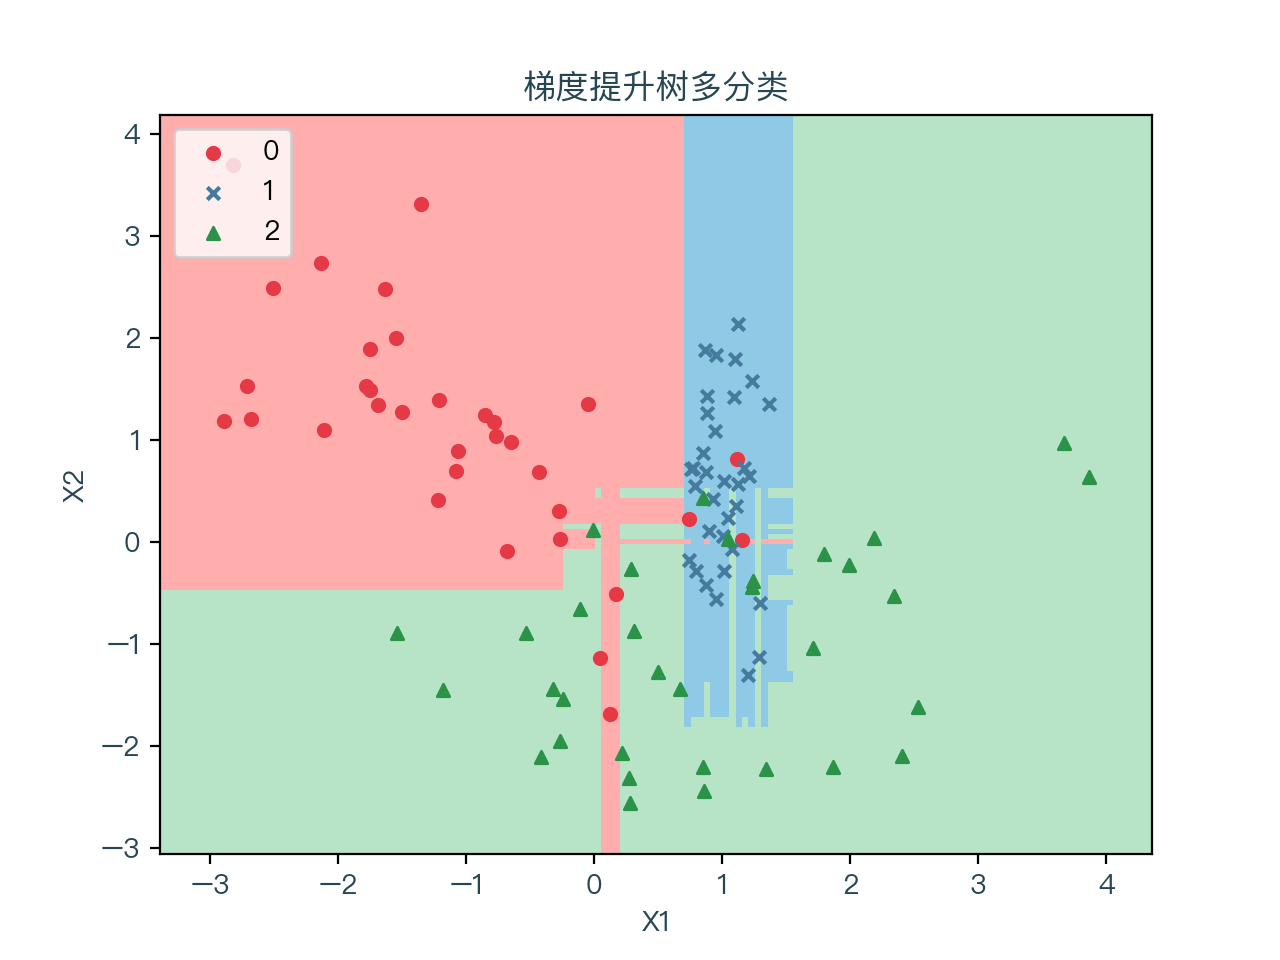

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6', "#b7e4c7"]
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==0][:, 0]
y1 = X[y==0][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
x3 = X[y==2][:, 0]
y3 = X[y==2][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)
p3 = plt.scatter(x3, y3, c='#2b9348', marker='^', s=20)

ax.set_title('梯度提升树多分类', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["0", "1", "2"], loc="upper left")
plt.show()

梯度提升树多分类（scikit-learn）：

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# 梯度提升树分类器
clf = GradientBoostingClassifier(n_estimators = 100)
# 拟合数据集
clf = clf.fit(X, y)

梯度提升树可视化（scikit-learn）：

<IPython.core.display.Javascript object>


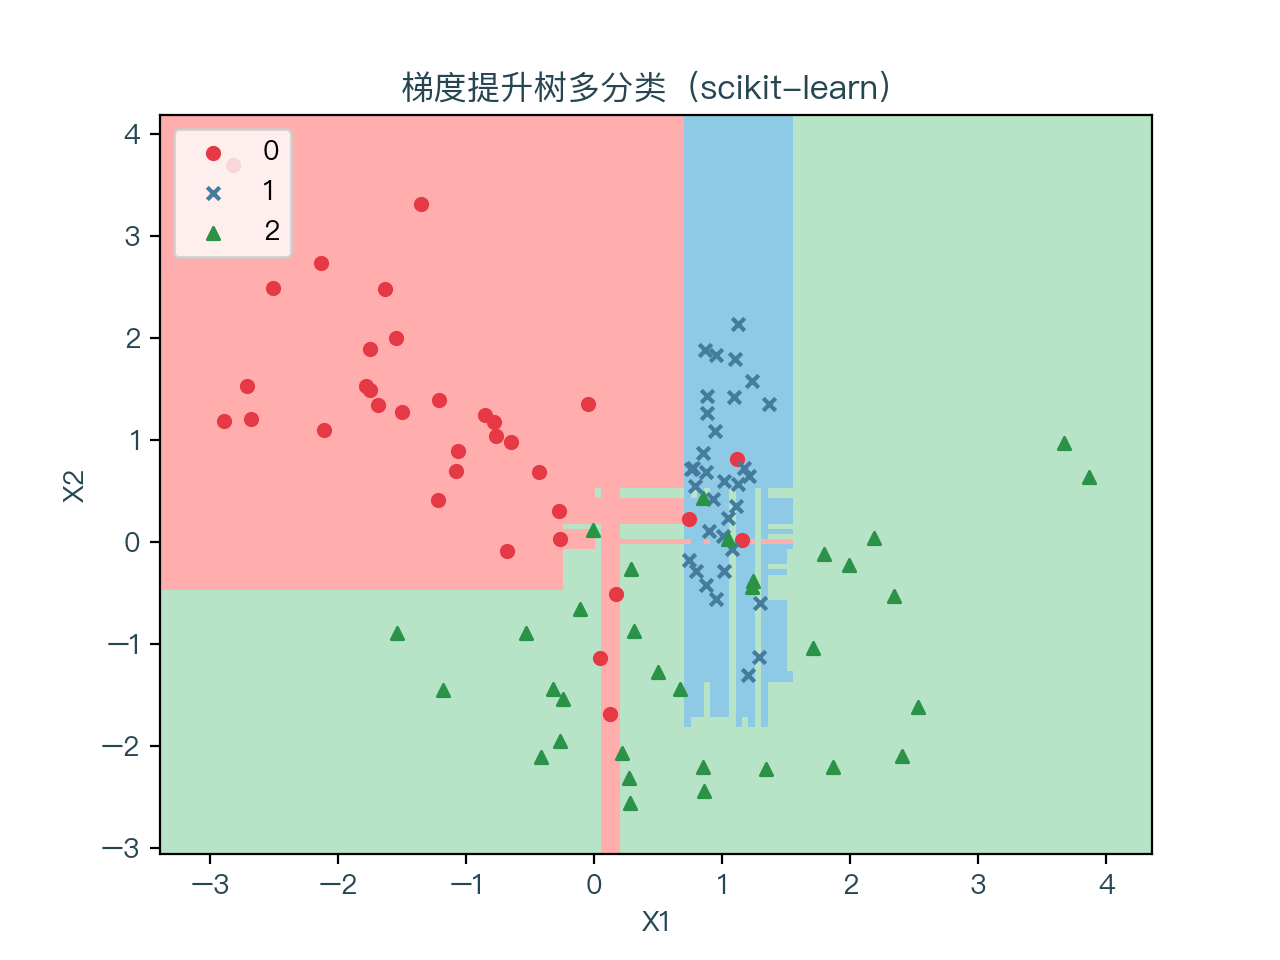

/Users/saisimon/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
clist=['#ffadad', '#8ecae6', "#b7e4c7"]
newcmp = LinearSegmentedColormap.from_list('point_color', clist)
plt.pcolormesh(xx, yy, Z, cmap = newcmp)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

x1 = X[y==0][:, 0]
y1 = X[y==0][:, 1]
x2 = X[y==1][:, 0]
y2 = X[y==1][:, 1]
x3 = X[y==2][:, 0]
y3 = X[y==2][:, 1]
p1 = plt.scatter(x1, y1, c='#e63946', marker='o', s=20)
p2 = plt.scatter(x2, y2, c='#457b9d', marker='x', s=20)
p3 = plt.scatter(x3, y3, c='#2b9348', marker='^', s=20)

ax.set_title('梯度提升树多分类（scikit-learn）', color='#264653')
ax.set_xlabel('X1', color='#264653')
ax.set_ylabel('X2', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.legend([p1, p2, p3], ["0", "1", "2"], loc="upper left")
plt.show()

生成回归样例数据：

In [13]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features = 1, n_targets = 1, n_samples = 100, noise = 5, random_state = 0)

梯度提升树回归实现：

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class gbdtr:
    """
    梯度提升树回归算法
    """
    
    def __init__(self, n_estimators = 100, learning_rate = 0.1):
        # 梯度提升树弱学习器数量
        self.n_estimators = n_estimators
        # 学习速率
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        """
        梯度提升树回归算法拟合
        """
        # 初始化 H0
        self.H0 = np.average(y)
        # 初始化预测值
        H = np.ones(X.shape[0]) * self.H0
        # 估计器数组
        estimators = []
        # 遍历 n_estimators 次
        for k in range(self.n_estimators):
            # 计算残差 y_hat
            y_hat = y - H
            # 初始化决策回归树估计器
            estimator = DecisionTreeRegressor(max_depth = 3)
            # 用 y_hat 拟合训练集
            estimator.fit(X, y_hat)
            # 使用回归树的预测值
            y_predict = estimator.predict(X)
            # 更新预测值
            H += self.learning_rate * y_predict
            estimators.append(estimator)
        self.estimators = np.array(estimators)
        
    def predict(self, X):
        """
        梯度提升树回归算法预测
        """
        # 初始化预测值
        H = np.ones(X.shape[0]) * self.H0
        # 遍历估计器
        for k in range(self.n_estimators):
            estimator = self.estimators[k]
            y_predict = estimator.predict(X)
            # 计算预测值
            H += self.learning_rate * y_predict
        return H

梯度提升树回归拟合：

In [15]:
reg = gbdtr()
reg.fit(X, y)

梯度提升树回归可视化：

<IPython.core.display.Javascript object>


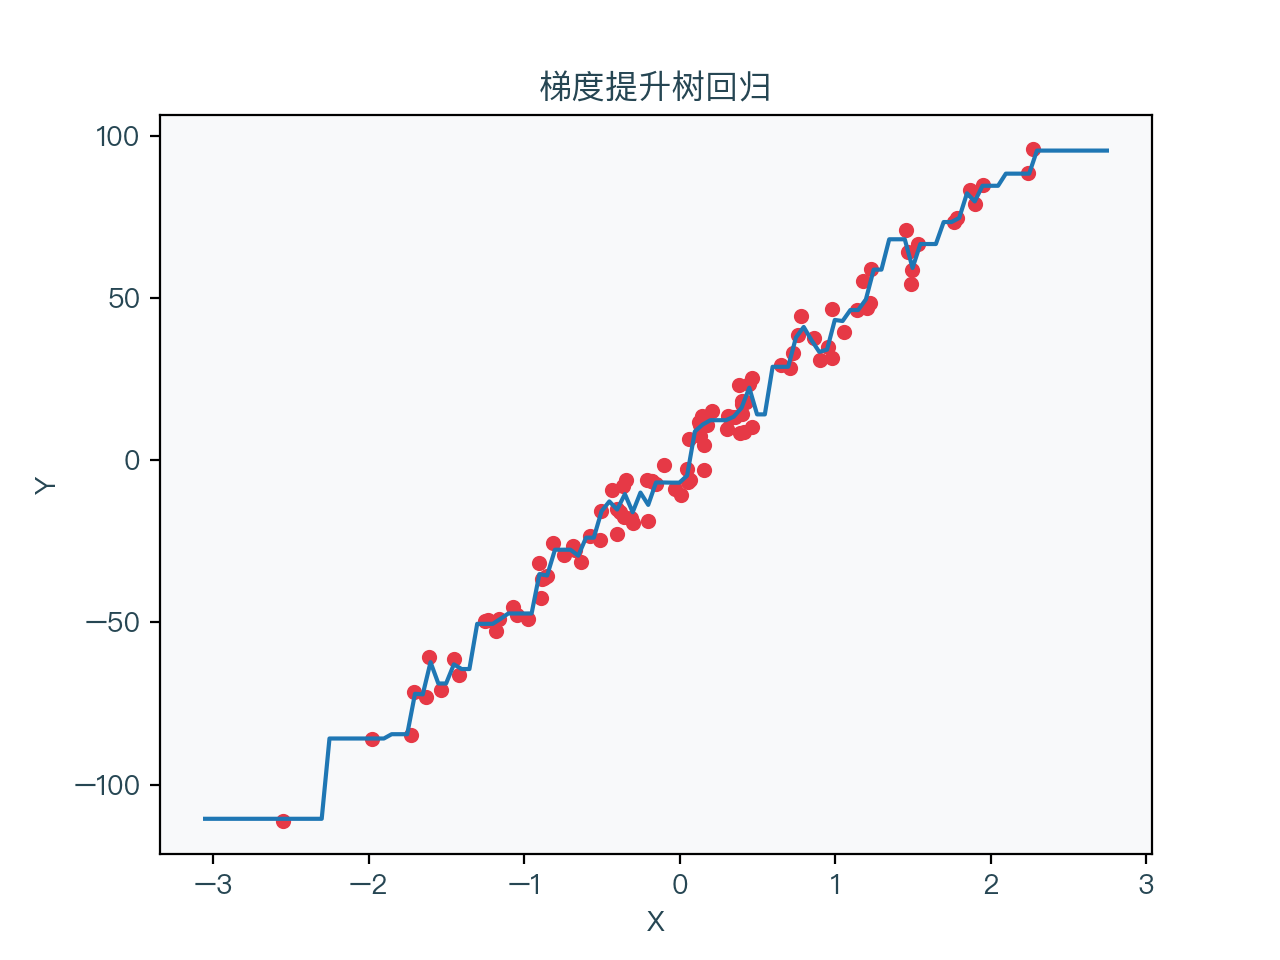

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .05)
yy = reg.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('梯度提升树回归', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()

梯度提升树回归（scikit-learn）：

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# 梯度提升树回归器
reg = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 0, loss = 'ls')
# 拟合数据集
reg = reg.fit(X, y)

梯度提升树回归可视化（scikit-learn）：

<IPython.core.display.Javascript object>


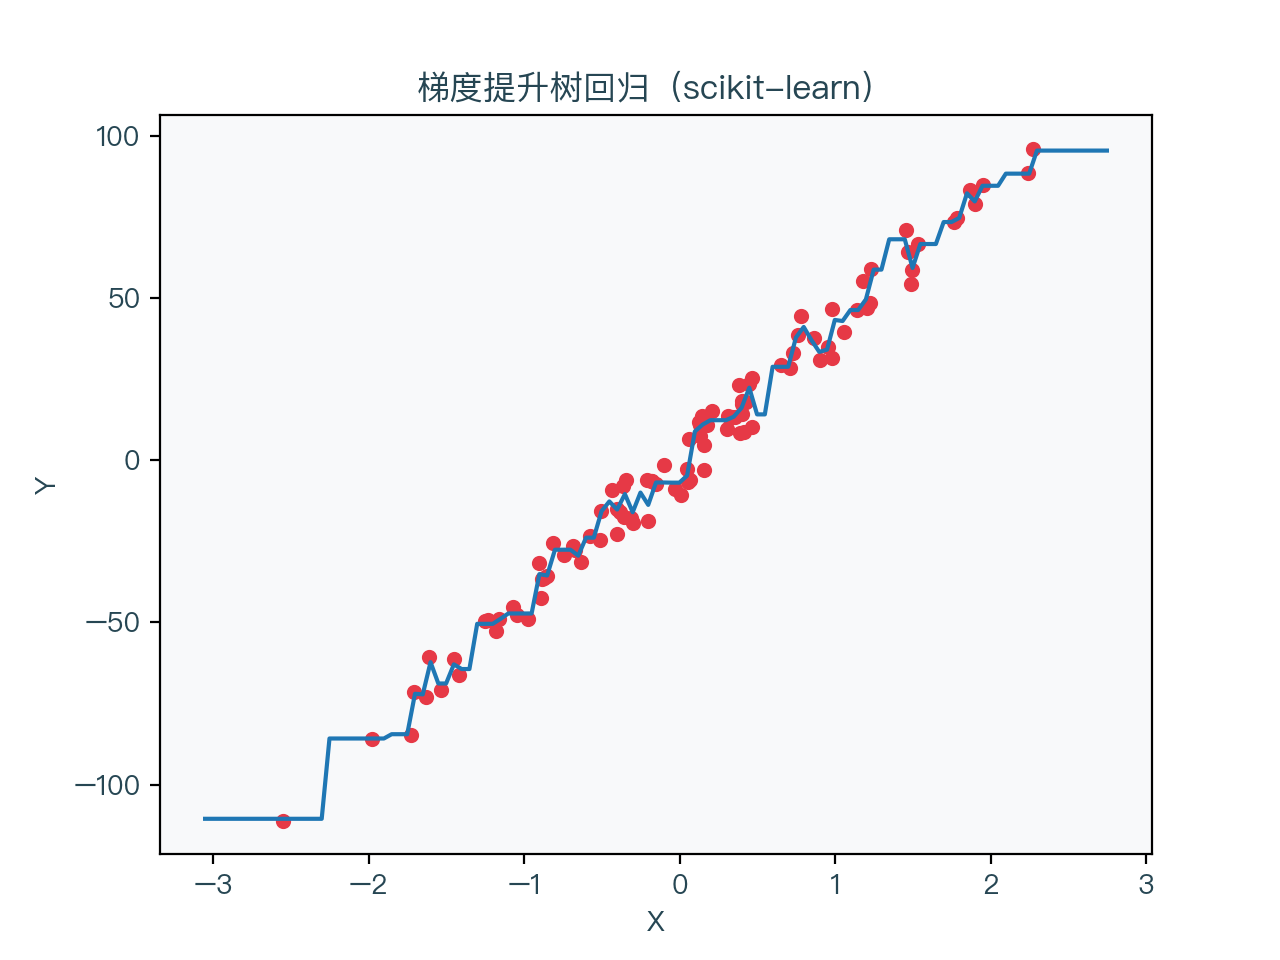

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

%matplotlib notebook

plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 选择一个本地的支持中文的字体
fig, ax = plt.subplots()
ax.set_facecolor('#f8f9fa')

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
xx = np.arange(x_min, x_max, .05)
yy = reg.predict(np.c_[xx.ravel()])

plt.scatter(X, y, c='#e63946', marker='o', s=20)
plt.plot(xx, yy)

ax.set_title('梯度提升树回归（scikit-learn）', color='#264653')
ax.set_xlabel('X', color='#264653')
ax.set_ylabel('Y', color='#264653')
ax.tick_params(labelcolor='#264653')
plt.show()